See also: [pytorch cartpole DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [1]:
# imports
from __future__ import annotations
import gym
import gym_cartpole_swingup
import torch
import torch.nn
import torch.nn.functional
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import tqdm
from dataclasses import dataclass
from itertools import count
import math

In [2]:
# config
%matplotlib ipympl

BATCH_SIZE = 128
MEMORY_SIZE = 10000 
MEMORY_WARMUP = 0

LEARNING_RATE = 0.001 
LEARNING_RATE_GAMMA = 0.9 
LEARNING_RATE_UPDATE_INTERVAL = 2000 

REWARD_GAMMA = 0.99   

EPSILON_START = 0.9
EPSILON_END = 0.05
EPSILON_DECAY = 200
EPSILON_SCALE = 15

PREVIEW_EPISODE_INTERVAL = 1 

POLICY_TARGET_UPDATE_INTERVAL = 10 
SOFT_UPDATE_TAU = 0.001  

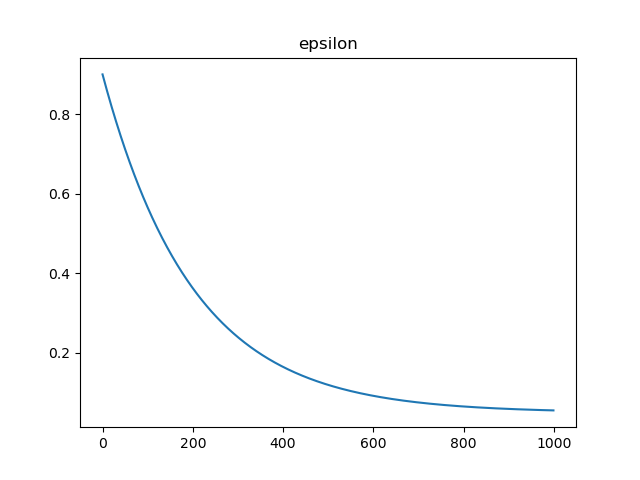

In [3]:
plt.figure()
plt.title("epsilon")
plt.plot([EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY) for steps_done in range(1000)])
plt.show()

In [4]:
# typedefs
State = torch.Tensor
Action = float
Reward = float
StateBatch = torch.Tensor
ActionBatch = torch.Tensor
RewardBatch = torch.Tensor
TerminalBatch = torch.Tensor

In [5]:
class DQN(torch.nn.Module):
    def __init__(self, num_actions: int):
        super().__init__()
        self.fc1 = torch.nn.Linear(5,16)
        self.bn1 = torch.nn.BatchNorm1d(16)
        self.fc2 = torch.nn.Linear(16,32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.fc3 = torch.nn.Linear(32,127)
        self.bn3 = torch.nn.BatchNorm1d(127)
        self.out = torch.nn.Linear(127, num_actions)
        # self.fc1 = torch.nn.LazyLinear(16)
        # self.bn1 = torch.nn.LazyBatchNorm1d()
        # self.fc2 = torch.nn.LazyLinear(32)
        # self.bn2 = torch.nn.LazyBatchNorm1d()
        # self.fc3 = torch.nn.LazyLinear(127)
        # self.bn3 = torch.nn.LazyBatchNorm1d()
        # self.out = torch.nn.LazyLinear(num_actions)

    def forward(self, x: StateBatch) -> ActionBatch:
        x = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        x = torch.nn.functional.relu(self.bn2(self.fc2(x)))
        x = torch.nn.functional.relu(self.bn3(self.fc3(x)))
        x = self.out(x)
        return x

In [6]:
# weight update functions
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26
def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            ## shouldn't be necessary since we use target networks to calculate loss
            # if isinstance(target_param, torch.nn.parameter.UninitializedParameter):
            #     # target model uninitialize, hard update
            #     target_param.data.copy_(param.data)
            # else:
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    target.load_state_dict(source.state_dict())
    # for target_param, param in zip(target.parameters(), source.parameters()):
    #         target_param.data.copy_(param.data)

In [7]:
# transitions
@dataclass
class Transition:
    state: State
    action: Action
    reward: Reward
    next_state: State
    terminal: bool

@dataclass
class TransitionBatch:
    states: StateBatch
    actions: ActionBatch
    rewards: RewardBatch
    next_states: StateBatch
    terminals: TerminalBatch

In [8]:
# env = gym.make("MountainCar-v0")
# env = gym.make("CartPoleSwingUp-v0")
env = gym.make("CartPoleSwingUp-v1")

In [9]:
print(env.observation_space)
print(env.reset())


Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (5,), float32)
[-0.00818036  0.00270634 -0.9913777   0.13103522 -0.03212784]


In [10]:
print(env.action_space)

Box(-1.0, 1.0, (1,), float32)


In [11]:
# action space
# for i in range(500):
#     action_space = torch.linspace(env.action_space.low.item(),env.action_space.high.item(),i).unsqueeze(1)
#     if 0 in action_space:
#         print(i)
action_space = torch.linspace(env.action_space.low.item(),env.action_space.high.item(),33).unsqueeze(1)
assert 0 in action_space # not sure if necessary but it _feels_ right
print(action_space, action_space.shape)

tensor([[-1.0000],
        [-0.9375],
        [-0.8750],
        [-0.8125],
        [-0.7500],
        [-0.6875],
        [-0.6250],
        [-0.5625],
        [-0.5000],
        [-0.4375],
        [-0.3750],
        [-0.3125],
        [-0.2500],
        [-0.1875],
        [-0.1250],
        [-0.0625],
        [ 0.0000],
        [ 0.0625],
        [ 0.1250],
        [ 0.1875],
        [ 0.2500],
        [ 0.3125],
        [ 0.3750],
        [ 0.4375],
        [ 0.5000],
        [ 0.5625],
        [ 0.6250],
        [ 0.6875],
        [ 0.7500],
        [ 0.8125],
        [ 0.8750],
        [ 0.9375],
        [ 1.0000]]) torch.Size([33, 1])


In [12]:
memory = deque(maxlen=MEMORY_SIZE)

In [13]:
def sample_memory(batch_size: int) -> TransitionBatch:
    samples = random.sample(memory, batch_size)
    return TransitionBatch(
        states=torch.stack([s.state for s in samples]),
        actions=torch.as_tensor([s.action for s in samples], dtype=torch.float32),
        rewards=torch.as_tensor([s.reward for s in samples], dtype=torch.float32),
        next_states=torch.stack([s.next_state for s in samples]),
        terminals=torch.as_tensor([s.terminal for s in samples], dtype=torch.bool),
    )

In [14]:
# instantiate models
policy = DQN(action_space.shape[0])
policy_target = DQN(action_space.shape[0])
policy_target.eval()

DQN(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=127, bias=True)
  (bn3): BatchNorm1d(127, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=127, out_features=33, bias=True)
)

In [15]:
def get_action(state: State, epsilon: float) -> Action:
    if random.random() < epsilon:
        return env.action_space.sample().item()
    state_batch = state.unsqueeze(0)
    policy.eval()
    with torch.no_grad():
        q_values = policy(state_batch)
    return action_space[q_values.argmax(dim=1).squeeze()].item() # return action with highest q-value

In [16]:
get_action(torch.as_tensor(env.reset(), dtype=torch.float32), 0.0)

0.0625

In [17]:
criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.MSELoss()

In [18]:
loss_history = []
learning_rate_history = []
reward_history = []
duration_history = []
action_history = []
terminal_history = []

In [19]:
# train loop

# optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.RMSprop(policy.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=LEARNING_RATE_UPDATE_INTERVAL,
    gamma=LEARNING_RATE_GAMMA,
)
steps_done = 0
warmup_steps = max(BATCH_SIZE,MEMORY_WARMUP)
with tqdm() as pbar:
    for episode in count():
        state = torch.as_tensor(env.reset(), dtype=torch.float32)

        for i in count():
            epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * ((steps_done-warmup_steps)/EPSILON_SCALE) / EPSILON_DECAY)
            steps_done += 1
            #region exploration
            action = get_action(state, epsilon)
            action_history.append(action)
            next_state, reward, done, info = env.step(action)
            reward_history.append(reward)
            terminal_history.append(done)
            if done:
                duration_history.append(i)
                next_state = torch.zeros(state.shape)
            else:
                next_state = torch.as_tensor(next_state, dtype=torch.float32)                
            memory.append(Transition(
                state=state,
                action=action,
                reward=reward,
                next_state=next_state,
                terminal=done,
            ))
            state = next_state
            if episode % PREVIEW_EPISODE_INTERVAL == 0:
                env.render()
            #endregion exploration

            if len(memory) < warmup_steps:
                pbar.set_description(f"warmup")
            else:
                policy.train()
                batch = sample_memory(BATCH_SIZE)

                # calculate q values for the actions that were taken
                distances = torch.cdist(batch.actions.unsqueeze(1), action_space)
                action_indices = torch.argmin(distances, dim=1)
                # taken = action_space[action_indices]
                q_pred = policy(batch.states).gather(1, action_indices.unsqueeze(1))

                # calculate q values for next state
                q_next = torch.zeros(BATCH_SIZE)
                non_final = ~batch.terminals
                q_next[non_final] = policy_target(batch.next_states[non_final]).max(dim=1).values.detach()

                # calculate expected q values
                q_expected = ((q_next * REWARD_GAMMA) + batch.rewards).unsqueeze(1)

                # calculate loss
                policy_loss = criterion(q_pred, q_expected)
                loss_history.append(policy_loss.item())

                # apply weight update
                optimizer.zero_grad()
                policy_loss.backward()
                for param in policy.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()
                
                # update learning rate
                learning_rate_history.append(scheduler.get_last_lr())
                scheduler.step()

                ## update target network
                # soft_update(policy_target, policy, SOFT_UPDATE_TAU)
                if i % POLICY_TARGET_UPDATE_INTERVAL == 0:
                    hard_update(policy_target, policy)

                pbar.set_description(f"policy: {policy_loss.item():.3f}, reward: {reward:.3f}, epsilon: {epsilon:.3f}, lr: {scheduler.get_last_lr()[0]:.4f}, steps: {steps_done}")
                
            if done: break

        pbar.update()
env.close()

0it [00:00, ?it/s]

KeyboardInterrupt: 

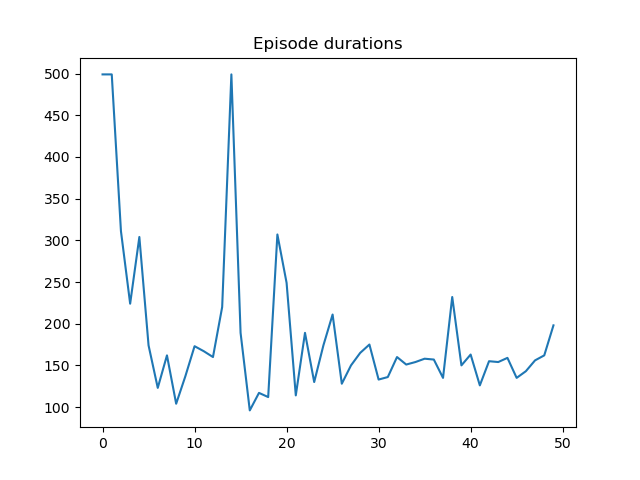

In [ ]:
# episode durations
plt.figure()
plt.plot(duration_history)
plt.title("Episode durations")
plt.show()

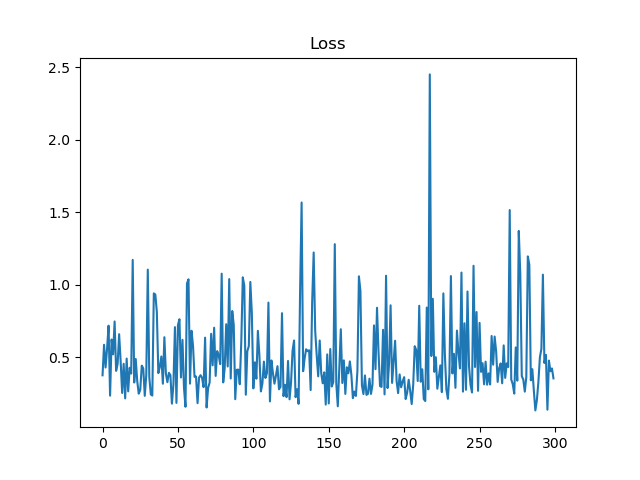

In [ ]:
# episode durations
plt.figure()
plt.plot(loss_history[-300:])
plt.title("Loss")
plt.show()

interactive(children=(IntSlider(value=9329, description='i', max=9428), IntSlider(value=100, description='wind…

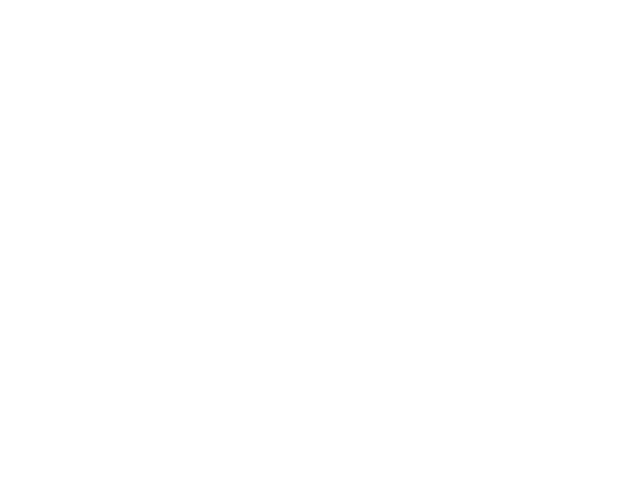

In [ ]:
# investigate actions
import ipywidgets as widgets
plt.figure()
@widgets.interact(i=(0, len(action_history)-1), window_size=(1, len(action_history)-1))
def preview_actions(i=len(action_history)-100, window_size=100):
    x = torch.zeros((len(action_history), env.action_space.n + 1))
    x[range(len(action_history)), action_history] = 1
    x[:, 2] = torch.as_tensor(terminal_history, dtype=torch.bool)
    plt.imshow(x[i:i+window_size], aspect="auto")
    plt.show()
    del x

In [ ]:
# preview
epsilon = 0
for _ in range(25):
    state = env.reset()
    done = False
    while not done:
        action = get_action(torch.as_tensor(state))
        next_state, reward, done, info = env.step(action)
        env.render()
        frame = env.render()
        state = next_state

env.close()

RuntimeError: expected scalar type Float but found Double